# Tensorflow Chessbot Learning Notebook

In this notebook we'll train a tensorflow neural network to tell what piece is on a chess square.
In the previous notebook we wrote scripts that parsed input images which contained a chessboard into 32x32 grayscale chess squares.

In [1]:
# Init and helper functions
import helper_functions as hf
import tensorflow as tf
import numpy as np
import glob

Let's load the tiles in for the training and test dataset

In [2]:
# All lichess tiles with pieces in starting position
train_paths = np.array(glob.glob("train_tiles/tiles_lichess_*/*.png"))
test_paths = np.array(glob.glob("test_tiles/tiles_lichess_*/*.png"))

# Training dataset
# Order of inputs must be the same for both images and labels
print "Loading %d Training tiles" % train_paths.size
train_images = hf.loadImages(train_paths)
train_labels = hf.loadLabels(train_paths)

print "Loading %d Training tiles" % test_paths.size
test_images = hf.loadImages(test_paths)
test_labels = hf.loadLabels(test_paths)

train_dataset = hf.DataSet(train_images, train_labels, dtype=tf.float32)
test_dataset = hf.DataSet(test_images, test_labels, dtype=tf.float32)

Loading 1536 Training tiles
On #0/1536 : train_tiles/tiles_lichess_10/lichess_10_E1.png
On #100/1536 : train_tiles/tiles_lichess_11/lichess_11_C3.png
On #200/1536 : train_tiles/tiles_lichess_29/lichess_29_C1.png
On #300/1536 : train_tiles/tiles_lichess_32/lichess_32_E8.png
On #400/1536 : train_tiles/tiles_lichess_35/lichess_35_C6.png
On #500/1536 : train_tiles/tiles_lichess_15/lichess_15_B3.png
On #600/1536 : train_tiles/tiles_lichess_12/lichess_12_C6.png
On #700/1536 : train_tiles/tiles_lichess_31/lichess_31_G7.png
On #800/1536 : train_tiles/tiles_lichess_27/lichess_27_F3.png
On #900/1536 : train_tiles/tiles_lichess_13/lichess_13_H3.png
On #1000/1536 : train_tiles/tiles_lichess_18/lichess_18_H6.png
On #1100/1536 : train_tiles/tiles_lichess_16/lichess_16_D3.png
On #1200/1536 : train_tiles/tiles_lichess_14/lichess_14_G1.png
On #1300/1536 : train_tiles/tiles_lichess_26/lichess_26_F6.png
On #1400/1536 : train_tiles/tiles_lichess_28/lichess_28_F2.png
On #1500/1536 : train_tiles/tiles_liche

Cool, lets look at a few images in the training set

0: Piece(K) : [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


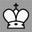

1: Piece(r) : [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


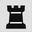

2: Piece(n) : [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


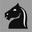

3: Piece( ) : [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


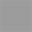

4: Piece( ) : [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


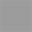

Some black knights
2: Piece(n) : [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


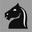

21: Piece(n) : [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


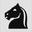

84: Piece(n) : [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


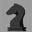

106: Piece(n) : [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


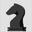

164: Piece(n) : [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


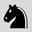

181: Piece(n) : [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]


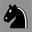

In [3]:
# Visualize a couple tiles
for i in range(5):
    print "%d: Piece(%s) : %s" % (i, hf.label2Name(train_dataset.labels[i]), train_dataset.labels[i])
    hf.display_array(np.reshape(train_dataset.images[i,:],[32,32]))

print "Some black knights"
for i in range(200):
    if hf.label2Name(train_dataset.labels[i]) is 'n': # n = Black Knight
        print "%d: Piece(%s) : %s" % (i, hf.label2Name(train_dataset.labels[i]), train_dataset.labels[i])
        hf.display_array(np.reshape(train_dataset.images[i,:],[32,32]))

Looks good. Now that we've loaded the data, let's build up a simple softmax regression classifier based off of [this beginner tutorial](https://www.tensorflow.org/versions/v0.6.0/tutorials/mnist/beginners/index.html) on tensorflow.

In [4]:
import tensorflow as tf

x = tf.placeholder(tf.float32, [None, 32*32])
W = tf.Variable(tf.zeros([32*32, 13]))
b = tf.Variable(tf.zeros([13]))

y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 13])

cross_entropy = -tf.reduce_sum(y_*tf.log(y))

train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)

init = tf.initialize_all_variables()


sess = tf.Session()
sess.run(init)

N = 1000
print "Training for %d steps..." % N
for i in range(N):
    batch_xs, batch_ys = train_dataset.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    if ((i+1) % 200) == 0:
        print "\t%d/%d" % (i+1, N)
print "Finished training."

Training for 1000 steps...
	200/1000
	400/1000
	600/1000
	800/1000
	1000/1000
Finished training.


In [5]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
print "Accuracy: %g\n" % sess.run(accuracy, feed_dict={x: test_dataset.images, y_: test_dataset.labels})

Accuracy: 0.9875



Woot! Around 98% accurate for this simple set, let's look at the weights to get an idea of what it sees for each piece.

Visualization of Weights as negative(Red) to positive(Blue)
Piece:  


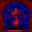

Piece: K


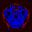

Piece: Q


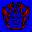

Piece: R


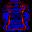

Piece: B


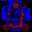

Piece: N


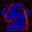

Piece: P


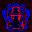

Piece: k


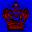

Piece: q


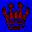

Piece: r


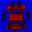

Piece: b


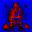

Piece: n


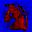

Piece: p


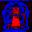

In [6]:
print "Visualization of Weights as negative(Red) to positive(Blue)"
for i in range(13):
    print "Piece: %s" % hf.labelIndex2Name(i)
    piece_weight = np.reshape(sess.run(W)[:,i], [32,32])
    hf.display_weight(piece_weight,rng=[-0.2,0.2])

Cool, you can see the shapes show up within the weights. Let's have a look at the failure cases to get a sense of what went wrong. TODO...